### Stacking with multiple regressors

In [24]:
import importlib
import helper_functions
import pandas as pd
importlib.reload(helper_functions)
from helper_functions import *
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion, _transform_one
from sklearn.externals.joblib import Parallel, delayed

In [25]:
# Defining pipeline as in other examples
trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('drop_features', DFTransform(lambda X: drop_features(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X)))
    ])

In [114]:
# Load the data
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_test = pd.read_csv('data/test.csv').drop(['Id'], axis=1)
X_train, y_train = prepare_inputs(X_train, y_train)

# Transforming the input
X_combined = pd.concat((X_train, X_test)).reset_index(drop=True) 
X_tranformed = trans_pipeline.fit_transform(X_combined)

# Split the transformed input back
X_train_trans = X_tranformed[:X_train.shape[0]] 
X_test_trans = X_tranformed[X_train.shape[0]:]

Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)


In [115]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_trans, y_train, test_size=.4, random_state=42)

In [116]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge

# Define first estimator
adaboost_estimator = AdaBoostRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         learning_rate=.001, loss='linear', n_estimators=100,
         random_state=42)

In [117]:
# Train the first estimator on the first subset
adaboost_estimator.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         learning_rate=0.001, loss='linear', n_estimators=100,
         random_state=42)

In [118]:
# Predict with the first estimator on the second subset
prediction_adaboost = adaboost_estimator.predict(X_train)

In [119]:
from sklearn.linear_model import Lasso

# Define second regressor
lasso_estimator = Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [120]:
# Train the second estimator on the first subset
lasso_estimator.fit(X_train, y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [121]:
# Predict with the second estimator on the second subset
prediction_lasso = lasso_estimator.predict(X_train)

In [122]:
from sklearn.metrics import make_scorer

def rmse_score(y_t, y_pred):
    return math.sqrt(mean_squared_error(y_t, y_pred))

In [134]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import GridSearchCV   
from sklearn.preprocessing import RobustScaler

param_dict = {'robust_scaler__with_scaling' : [True, False],
              'robust_scaler__with_centering' : [True, False],
              'ridge_regression__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]
             }
     
scorer = make_scorer(rmse_score, greater_is_better=False)
parameter_estimator = GridSearchCV(Pipeline([
        ('robust_scaler', RobustScaler()),
        ('ridge_regression', Ridge(solver='cholesky'))
            ]), param_dict, scoring=scorer)

parameter_estimator.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('robust_scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridge_regression', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'robust_scaler__with_scaling': [True, False], 'robust_scaler__with_centering': [True, False], 'ridge_regression__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

In [135]:
# Not we define a bagging ensemble for the blending
bagging_estimator = parameter_estimator.best_estimator_

In [136]:
# This blender now we train on the predictions of the first layer
X_blended = np.column_stack((prediction_lasso, prediction_adaboost))

bagging_estimator.fit(X_blended, y_train)

Pipeline(memory=None,
     steps=[('robust_scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
       with_scaling=True)), ('ridge_regression', Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001))])

In [137]:
# And now we use the stack to make a prediction on unseen data
test_prediction_ada = adaboost_estimator.predict(X_test)
test_prediction_lasso = lasso_estimator.predict(X_test)

X_test_blended = np.column_stack((test_prediction_lasso, test_prediction_ada))
y_predicted = bagging_estimator.predict(X_test_blended)

In [138]:
print_benchmark(y_test, y_predicted)

R2-score: 0.91285090301
RMSE (log): 0.11802606038596741


In [147]:
# Now we train and execute the stacked model on complete data set
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_test = pd.read_csv('data/test.csv').drop(['Id'], axis=1)
X_train, y_train = prepare_inputs(X_train, y_train)

# Transforming the input
X_combined = pd.concat((X_train, X_test)).reset_index(drop=True) 
X_tranformed = trans_pipeline.fit_transform(X_combined)

# Split the transformed input back
X_train_trans = X_tranformed[:X_train.shape[0]] 
X_test_trans = X_tranformed[X_train.shape[0]:]

Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)


In [153]:
X_train_trans.shape

(1456, 219)

In [156]:
adaboost_estimator.fit(X_train_trans, y_train)
lasso_estimator.fit(X_train_trans, y_train)

test_prediction_ada = adaboost_estimator.predict(X_test_trans)
test_prediction_lasso = lasso_estimator.predict(X_test_trans)

X_test_blended = np.column_stack((test_prediction_lasso, test_prediction_ada))

In [158]:
y_predicted = bagging_estimator.predict(X_test_blended)

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 178911.40
Difference in means is: -2009.79956742


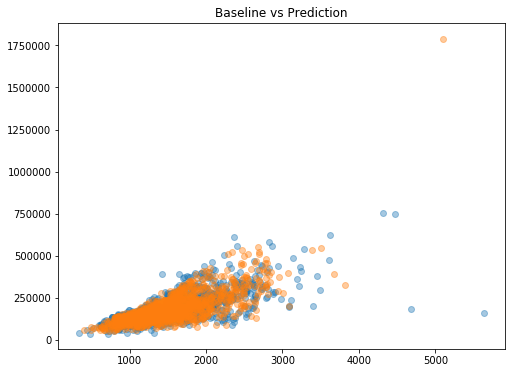

In [160]:
draw_sanity_check(y_predicted, False)

In [162]:
write_submission(y_predicted, False)

File written to C:\Source\predicting-house-prices\submissions\20180820195654.csv
